    Расчёт снеговой нагрузки по СП 20.13330.2016

In [32]:
import numpy as np
import pandas as pd
import math
import unicodedata as ucd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from tabulate import tabulate

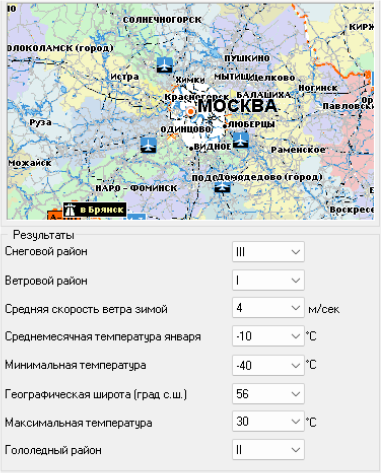

                 типы местности:

A - открытые побережья морей, озер и водохранилищ, сельские местности, в том числе с постройками высотой менее 10 м, пустыни, степи, лесостепи, тундра;

B - городские территории, лесные массивы и другие местности, равномерно покрытые препятствиями высотой более 10 м;

C - городские районы с плотной застройкой зданиями высотой более 25 м.


In [33]:
#@title Исходные данные
#@markdown Form
snow_region = "III" #@param ["I", "II", "III", "IV", "V", "VI", "VII", "VIII"] {allow-input: true}
terrain = "B" #@param ["A", "B", "C"] {allow-input: true}
structure = "building" #@param  ["building", "tower"] {allow-input: true}
protect = "no" #@param ["yes", "no"] {allow-input: true}
#@markdown ---

In [34]:
htop = 59.4 # высота высокого здания
dtop = 16 # "размер высокого здания в направлении, перпендикулярном расчетному направлению ветра"
ztop = 59.55 # высота высокого здания от поверхности земли
hbot = 54.6 # высота низкого здания
dbot = 18 # "размер низкого здания в направлении, перпендикулярном расчетному направлению ветра"
zbot = 54.75 # высота низкого здания от поверхности земли
btop = 16 # наименьший размер верхнего покрытия в плане
ltop = 21.4 # наибольший размер верхнего покрытия в плане
bbot = 18 # наименьший размер нижнего покрытия в плане
lbot = 21.6 # наибольший размер нижнего покрытия в плане
slopetop = 0 # уклон верхнего покрытия
slopebot = 0 # уклон нижнего покрытия
hptop = 0.4 # высота парапета верхнего покрытия
hpbot = 0.9 # высота парапета нижнего покрытия
tjan = -10 # среднемесячная температура воздуха в январе
atop = 0 # уклон двускатного верхнего покрытия
abot = 0 # уклон двускатного нижнего покрытия
ct = 1 # термический коэффициент
gf = 1.4 # Коэффициент надежности по нагрузке

In [35]:
index=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII']
table_10_1 = pd.Series([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], index=index)
print('            Таблица 10.1')
print(tabulate (pd.DataFrame(table_10_1).transpose(), showindex=False, headers=index))

            Таблица 10.1
  I    II    III    IV    V    VI    VII    VIII
---  ----  -----  ----  ---  ----  -----  ------
0.5     1    1.5     2  2.5     3    3.5       4


In [36]:
Sg = table_10_1[snow_region]
display(Math (r'нормативное \ значение \ веса \ снегового \ покрова \ Sg = {0} \ кПа'.format(Sg)))

<IPython.core.display.Math object>

In [37]:
columns=['Ze', 'A', 'B', 'C']
table_11_2 = pd.DataFrame(np.array([[5, 0.75, 0.5, 0.4],
                                   [10, 1, 0.65, 0.4],
                                   [20, 1.25, 0.85, 0.55],
                                   [40, 1.5, 1.1, 0.8],
                                   [60, 1.7, 1.3, 1],
                                   [80, 1.85, 1.45, 1.15],
                                   [100, 2, 1.6, 1.25],
                                   [150, 2.25, 1.9, 1.55],
                                   [200, 2.45, 2.1, 1.8],
                                   [250, 2.65, 2.3, 2],
                                   [300, 2.75, 2.5, 2.2]]),
                                  columns=columns)
table_11_2 = table_11_2.set_index(['Ze'])
print('    Таблица 11.2')
print(tabulate(table_11_2, headers=columns, showindex="always"))

    Таблица 11.2
  Ze     A     B     C
----  ----  ----  ----
   5  0.75  0.5   0.4
  10  1     0.65  0.4
  20  1.25  0.85  0.55
  40  1.5   1.1   0.8
  60  1.7   1.3   1
  80  1.85  1.45  1.15
 100  2     1.6   1.25
 150  2.25  1.9   1.55
 200  2.45  2.1   1.8
 250  2.65  2.3   2
 300  2.75  2.5   2.2


In [38]:
def zei(z, d, h):
    if structure == "building":
        if h <= z:
            ze = h
        elif d < h <= 2 * d:
            if z >= h - d:
                ze = h
            elif 0 < z < h - d:
                ze = d
            else:
               ze = z
        elif h > 2 * d:
            if z >= h - d:
                ze = h
            elif d < z < h - d:
                ze = z
            elif 0 <= z <= d:
                ze = d
            else:
              ze = z
        else:
            ze = z
    return ze

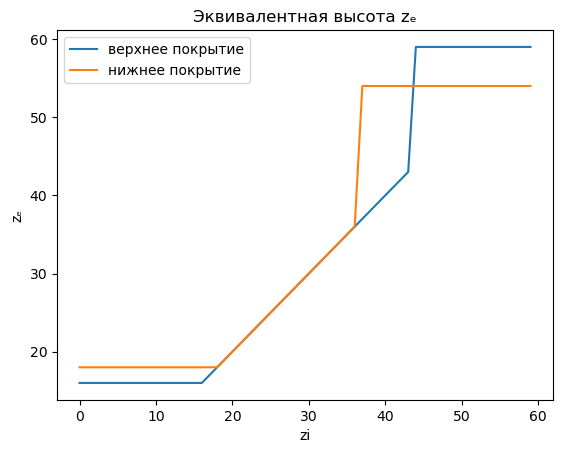

In [39]:
zi = np.arange(0, htop)
vzei = np.vectorize(zei)
zetopi = vzei(zi, dtop, htop)
zeboti = vzei(zi, dbot, hbot)
plt.plot(zi, zetopi, label='верхнее покрытие')
plt.plot(zi, zeboti, label='нижнее покрытие')
plt.legend()
plt.xlabel('zi')
plt.ylabel('z\u2091')
plt.title('Эквивалентная высота z\u2091')
plt.show()

In [40]:
def ki(tbl, z):
    tbl.index = pd.to_numeric(tbl.index)
    new_index = np.unique(list(tbl.index) + [z])
    new_tbl = tbl.reindex(new_index).interpolate(method='polynomial', order=2)
    k = new_tbl[terrain][z]
    return k

In [41]:
zetop = zei(ztop, dtop, htop)
zebot = zei(zbot, dbot, hbot)
print("Эквивалентная высота: верхнее покрытие z\u2091= {0:.3f} м, нижнее покрытие z\u2091= {1:.3f} м".format(zetop, zebot))
tbl = table_11_2
ktop = ki(tbl, zetop)
kbot = ki(tbl, zebot)
print("Коэффициент k: верхнее покрытие k= {0:.3f}, нижнее покрытие k= {1:.3f}".format(ktop, kbot))

Эквивалентная высота: верхнее покрытие zₑ= 59.400 м, нижнее покрытие zₑ= 54.600 м
Коэффициент k: верхнее покрытие k= 1.295, нижнее покрытие k= 1.251


In [42]:
def lci(b,l):
    lc = 2 * b - b**2/l
    if lc > 100:
        lc = 100
    else:
        lc = lc
    return lc

In [43]:
lctop = lci(btop, ltop)
lcbot = lci(bbot, lbot)

In [44]:
def cei(slope, k, lc):
    if terrain == "A" or terrain == "B":
        if slope < 12 and protect == "no":
            ce = (1.4 - 0.4 * math.sqrt(k)) * (0.8 + 0.002 * lc)
        elif 12 <= slope <= 20 and protect == "no":
            ce = 0.85
        else:
            ce = 1
    else:
        ce = 1
    if ce < 0.5:
        ce = 0.5
    if tjan > -5:
        ce = 1
    return ce

In [45]:
cetop = cei(slopetop, ktop, lctop)
cebot = cei(slopebot, kbot, lcbot)
print("Коэффициент, учитывающий снос снега с покрытий зданий под действием ветра или иных факторов: верхнее покрытие c\u2091= {0:.3f}, нижнее покрытие c\u2091= {1:.3f}".format(cetop, cebot))

Коэффициент, учитывающий снос снега с покрытий зданий под действием ветра или иных факторов: верхнее покрытие cₑ= 0.794, нижнее покрытие cₑ= 0.802


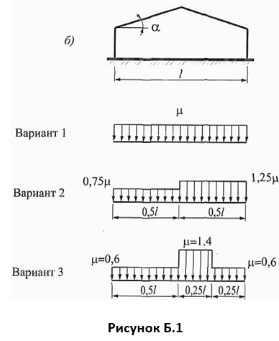

In [46]:
def mu_i(alpha):
    if alpha <= 30.0:
        mu = 1.0
    elif 30.0 < alpha < 60.0:
        mu = 1.0 - (alpha - 30.0) / 30.0
    else:
        mu = 0.0
    return mu

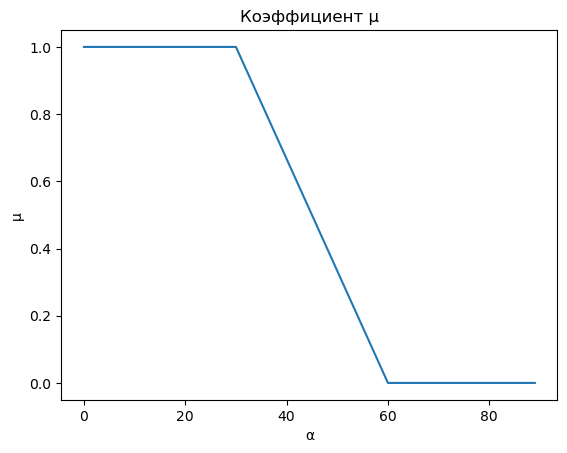

верхнее покрытие μ=1.000
нижнее покрытие μ=1.000


In [47]:
vmu_i = np.vectorize(mu_i)
ai = np.arange(0, 90)
mui = vmu_i(ai)
plt.plot(ai, mui)
plt.xlabel(ucd.lookup("GREEK SMALL LETTER ALPHA"))
plt.ylabel(ucd.lookup("GREEK SMALL LETTER MU"))
plt.title(r'Коэффициент '+ ucd.lookup("GREEK SMALL LETTER MU"))
plt.show()
mutop = mu_i(atop)
print("верхнее покрытие " + ucd.lookup("GREEK SMALL LETTER MU") + "={:.3f}".format(mutop))
mubot = mu_i(abot)
print("нижнее покрытие " + ucd.lookup("GREEK SMALL LETTER MU") + "={:.3f}".format(mubot))

Нормативное значение снеговой нагрузки на горизонтальную проекцию покрытия: $S_0(c_e,c_t,\mu) = c_e * c_t * \mu * S_g$

In [48]:
S0_top = cetop * ct * mutop * Sg
print("верхнее покрытие " + ucd.lookup("GREEK SMALL LETTER ALPHA") + "= {:.3f}\N{DEGREE SIGN} ---> S\u2080={:.3f} кПа".format(atop, S0_top))
S0_bot = cebot * ct * mubot * Sg
print("нижнее покрытие " + ucd.lookup("GREEK SMALL LETTER ALPHA") + "= {:.3f}\N{DEGREE SIGN} ---> S\u2080={:.3f} кПа".format(abot, S0_bot))

верхнее покрытие α= 0.000° ---> S₀=1.191 кПа
нижнее покрытие α= 0.000° ---> S₀=1.203 кПа


In [49]:
def sri(mu, S0):
    if tjan <= -5:
        s = 0.5 * mu * Sg
    else:
        s = S0
    return s

In [50]:
srtop = sri(mutop, S0_top)
srbot = sri(mubot, S0_bot)
print("Пониженное нормативное значение снеговой нагрузки: верхнее покрытие Sr= {0:.3f} кПа,  нижнее покрытие Sr= {1:.3f} кПа".format(srtop, srbot))

Пониженное нормативное значение снеговой нагрузки: верхнее покрытие Sr= 0.750 кПа,  нижнее покрытие Sr= 0.750 кПа


Расчетное значение нагрузки: $S(\gamma_f,S_0) = \gamma_f * S_0$

In [51]:
S_top1 = gf * S0_top
S_bot1 = gf * S0_bot
print("Расчетное значение нагрузки по 1-му предельному состоянию: верхнее покрытие S= {0:.3f} кПа, нижнее покрытие S= {1:.3f} кПа".format(S_top1, S_bot1))
S_top2 = S0_top
S_bot2 = S0_bot
print("Расчетное значение нагрузки по 2-му предельному состоянию: верхнее покрытие S= {0:.3f} кПа, нижнее покрытие S= {1:.3f} кПа".format(S_top2, S_bot2))

Расчетное значение нагрузки по 1-му предельному состоянию: верхнее покрытие S= 1.667 кПа, нижнее покрытие S= 1.684 кПа
Расчетное значение нагрузки по 2-му предельному состоянию: верхнее покрытие S= 1.191 кПа, нижнее покрытие S= 1.203 кПа


                                Б.8 Здания с перепадом высоты
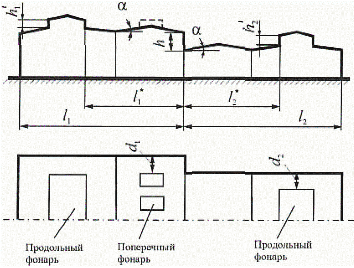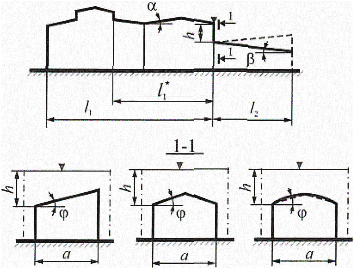

In [52]:
alpha1 = 0
alpha2 = 0
beta = 0
fi = 0
a = 18
S08 = Sg
h8 = 4.8
l1 = ltop
l1_=l1
l2 = lbot
if l2 > 3 * a:
    l2_ = 3 * a
else:
    l2_ = l2

In [53]:
def mi(alpha):
    if alpha <= 20:
        mu = 0.4
    else:
        mu = 0.3
    return mu

In [54]:
m1 = mi(alpha1)
k1 = math.sqrt(a / 21)
if beta >= 0:
    k2 = 1 - beta / 35
else:
    k2 = 1
k = 1 - beta / 30
if k < 0.3:
    k3 = 0.3
else:
    k3 = k
print("Коэффициенты: k1= {0:.3f}  k2= {1:.3f}, k3= {1:.3f}".format(k1, k2, k3))

Коэффициенты: k1= 0.926  k2= 1.000, k3= 1.000


In [55]:
m2 = 0
if a < 21:
    m2 =0.5 * k1 * k2 * k3
elif m2 < 0.1:
    m2 = 0.1
else:
    m2 = mi(alpha2)
print("Коэффициенты: m1= {0:.3f}, m2= {1:.3f}".format(m1, m2))

Коэффициенты: m1= 0.400, m2= 0.463


In [56]:
mumax1 = 2* h8 / S08
if l1_ <= 48 and l2_ <= 48:
    mumax2 = 4
elif l1_ > 72:
    mumax2 = 6
elif l2_ > 72:
    mumax2 = 6
else:
    mumax2 = 4 + (2 * max(l1_, l2_) - 48) / 24
mumax = min(mumax1, mumax2)

Коэффициент $\mu: \mu(h_8) = 1 + 1 / h_8 * (m_1 * l_1' + m_2 * l_2')$

In [57]:
mu_8 =1 + 1 / h8 *(m1 * l1_ + m2 * l2_)
if mu_8 > mumax:
    mu8 = mumax
else:
   mu8 = mu_8
print(ucd.lookup("GREEK SMALL LETTER MU") + "= {0:.3f}".format(mu8))

μ= 4.000


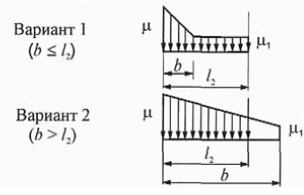

In [58]:
if mu_8 <= 2 * h8 / S08:
    b = 2 * h8
else:
    b = (mu_8 - 1 + 2 * m2) / (2 * h8 / S08 - 1 + 2 * m2) * 2 * h8
if b > 16:
    b8 = 16
elif b > 5 * h8:
    b8 = 5 * h8
else:
    b8 = b
print("Длина зоны повышенных снегоотложений b= {0:.3f} м".format(b8))

Длина зоны повышенных снегоотложений b= 9.600 м


In [59]:
if b8 >= l2_:
    mu1 = 1 - 2 * m2
elif mu_8 <= 2 * h8 / S08 and hpbot == 0:
    mu1 = 1 - 2 * m2
elif l2_ > b8 and mu_8 <= 2 * h8 / S08 and hpbot > 0:
    mu1 = 1 - m2 * l2_ / (l2_ - h8)
else:
    mu1 = (l2_ - 0.5 * mu8 * b8) / (l2_ - 0.5 * b8)
if mu1 < 0.2:
    mu1 = 0.2
print(ucd.lookup("GREEK SMALL LETTER MU") + "\u2081= {0:.3f}".format(mu1))

μ₁= 0.405


                Б.13 Покрытие с парапетами
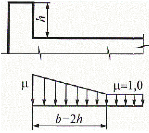

In [60]:
S0p = Sg

In [61]:
def mup_i(hp):
    if hp > S0p / 2:
        mup = 2 * hp /S0p
    else:
        mup = 1
    if mup > 3:
        mu = 3
    else:
        mu = mup
    return mu

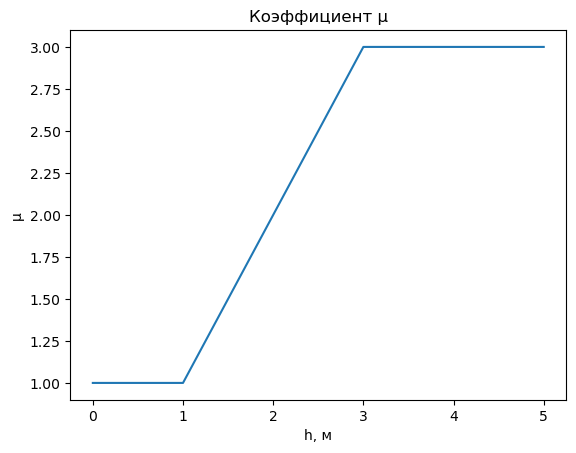

верхнее покрытие μ= 1.000
нижнее покрытие μ= 1.200
верхнее покрытие b= 0.800
нижнее покрытие b= 1.800


In [62]:
vmup_i = np.vectorize(mup_i)
hpi = np.arange(0, 6)
mupi = vmup_i(hpi)
plt.plot(hpi, mupi)
plt.xlabel("h, м")
plt.ylabel(ucd.lookup("GREEK SMALL LETTER MU"))
plt.title(r'Коэффициент '+ ucd.lookup("GREEK SMALL LETTER MU"))
plt.show()
mup_top = mup_i(hptop)
mup_bot = mup_i(hpbot)
bp_top = 2 * hptop
bp_bot = 2 * hpbot
print("верхнее покрытие " + ucd.lookup("GREEK SMALL LETTER MU") + "= {0:.3f}".format(mup_top))
print("нижнее покрытие " + ucd.lookup("GREEK SMALL LETTER MU") + "= {0:.3f}".format(mup_bot))
print("верхнее покрытие b= {0:.3f}".format(bp_top))
print("нижнее покрытие b= {0:.3f}".format(bp_bot))